## 3.1 Compute frequencies for subset

In [14]:
import pandas as pd
from tqdm import tqdm
import errant
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [15]:
nlp = spacy.load('en_core_web_sm')
annotator = errant.load('en', nlp)

df = pd.read_csv("./data/data_corrected.csv")


# compute error tags for corrected sentences
error_types = []
for i in tqdm(range(len(df))):
    temp_data = df.iloc[i]
    orig = annotator.parse(temp_data['original'])
    cor = annotator.parse(temp_data['corrected'])
    edits = annotator.annotate(orig, cor)
    for e in edits:
        error_types.append(e.type)
        
error_df = pd.DataFrame(columns = ['type'], data=error_types)

# save error count for each error in a dataframe
# use normalize=True for percentage
freq = pd.DataFrame(error_df.value_counts(), columns=['count'])
freq = freq.reset_index()
freq.to_csv('./data/error_freq.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 1887/1887 [01:00<00:00, 31.04it/s]


C:\Users\thoma\AppData\Local\Temp\ipykernel_13076\1245760687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.barplot(x='type', y='count', data=freq, palette='CMRmap')


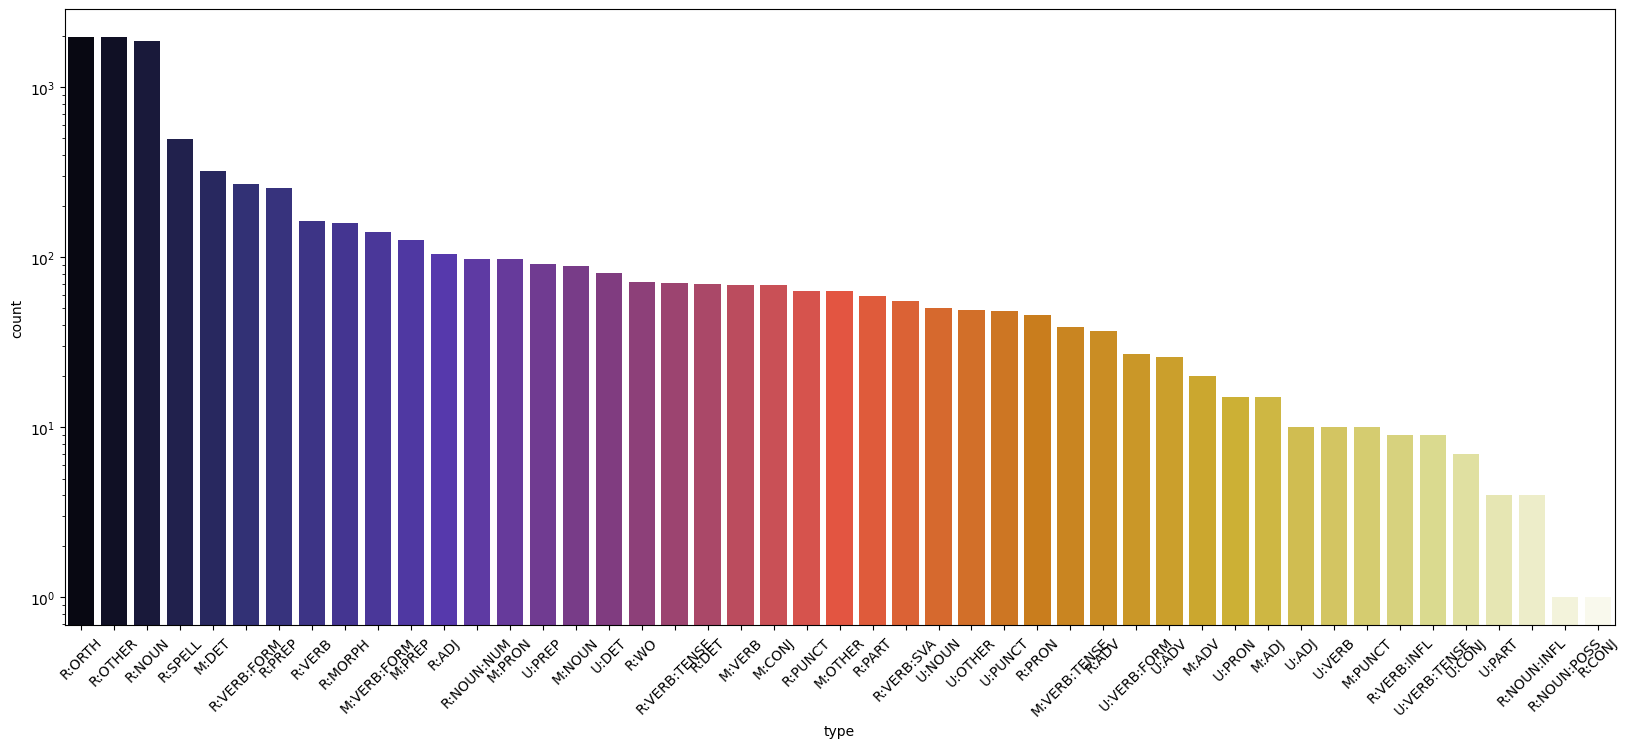

In [23]:
# plot error count
plt.figure(figsize=(20,8))
pl = sns.barplot(x='type', y='count', data=freq, palette='CMRmap')
plt.xticks(rotation=45)

pl.axes.set_yscale('log')
plt.show()

## 3.2 Select sample from large dataset

Select sample from [C4_200m](https://huggingface.co/datasets/liweili/c4_200m) dataset:  https://huggingface.co/datasets/liweili/c4_200m/blob/refs%2Fconvert%2Fparquet/default/partial-train/0001.parquet

In [3]:
parq = pd.read_parquet('./data/0001.parquet', engine='fastparquet')
df = parq.head(50000)

nlp = spacy.load('en_core_web_sm')
annotator = errant.load('en', nlp)

# Tag errors for sentence pairs
for i in tqdm(range(len(df))):
    temp_data = df.iloc[i]
    orig = annotator.parse(temp_data['input'])
    cor = annotator.parse(temp_data['output'])
    edits = annotator.annotate(orig, cor)
    df.loc[i, 'errors'] = str([e.type for e in edits]).replace('[', '').replace(']','').replace("'",'')
        
df.to_csv("./data/errors50k.csv")

  0%|          | 0/50000 [00:00<?, ?it/s]/var/folders/pl/wj42m65s2ng3tpsb296dtstc0000gn/T/ipykernel_21819/3126753873.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, 'errors'] = str([e.type for e in edits]).replace('[', '').replace(']','').replace("'",'')
100%|██████████| 50000/50000 [08:20<00:00, 99.85it/s] 


## 3.3 Recreate dataset with similar frequencies

In [ ]:
dataset_size = 10000
freqs = pd.read_csv("./data/error_freq.csv")
sentences = pd.read_csv("./data/errors50k.csv")

err_counter = pd.DataFrame(columns=["type", "numbers"])
matches =['M:VERB:FORM', 'R:PART', 'U:VERB:FORM', 'M:CONJ', 'R:ORTH']
important_matches = ['U:OTHER']
even_more_important = ['M:VERB:FORM']

def matcher(x):
    if pd.isna(x):
        return 0
    for i in even_more_important:
        if i.lower() in x.lower():
            return 3
    for i in important_matches:
        if i.lower() in x.lower():
            return 2
    for i in matches:
        if i.lower() in x.lower():
            return 1
    else:
        return 0


sentences['firstt'] = sentences['errors'].apply(matcher)

In [ ]:
for i in freqs.iterrows():
    err_counter = pd.concat([err_counter, pd.DataFrame([[i[1]['type'], round(dataset_size * i[1]['proportion'])]], columns=["type", "numbers"])])

    
s = sentences.firstt.sort_values(ascending=False).index

sentences = sentences.reindex(s)

err_counter.set_index("type", inplace=True)

result = pd.DataFrame(columns=["input", "target", "errors"])
uerrors = 0
for sentence in sentences.iterrows():
    if pd.isna(sentence[1]["errors"]):
        continue
    errors = sentence[1]["errors"].split(", ")
    if 'M:VERB:FORM' in errors:
        uerrors += 1
    add = True
    for error in errors:
        if not(error in err_counter.index) or err_counter.loc[error][0] <= 0:
            add = False

    if add:
        result = pd.concat([result, pd.DataFrame([{"input": sentence[1]["input"], "target": sentence[1]["output"], "errors": sentence[1]["errors"]}])])
        for error in errors:
            err_counter.loc[error][0] -= 1

In [ ]:
result.to_csv("./data/10k2.csv", index=False)